In [1]:
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.utils import to_categorical
import os
import shutil
import random
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Prepearing folders

In [6]:
os.makedirs('data/train/positive')
os.makedirs('data/train/negative')

os.makedirs('data/valid/positive')
os.makedirs('data/valid/negative')

os.makedirs('data/test/positive')
os.makedirs('data/test/negative')

In [ ]:
positive_path = "images/prepared/good/"

negative_path = "images/prepared/wrong/"

#train set 80% , validation set 10% (50% of 20%), test set 10% (remaining part)
percents = [.8 , .5, 1]
datasets = ['data/train', 'data/valid', 'data/test']


file_number = 0

for (i, percent) in enumerate(percents):
    n = 0
    
    for folder in os.listdir(negative_path):
        path = negative_path + folder
        size = len(os.listdir(path))
        
        for file in random.sample(os.listdir(path), int(size * percent)):
            shutil.move(path + '/' + file, datasets[i] + '/negative/' + str(n) + Path(path + '/' + file).suffix)
            n += 1
            file_number += 1
            
print('Negative dataset done! ' + str(file_number) + ' files moved')

file_number = 0
#I want to have equaly distributed examples from negative folders to avoid scenario of geting only few images of 
#head in wrong possitions and to much images of corridors (i want to make sure that training,valid and test set comes from the same distribution)
for (i, percent) in enumerate(percents):
    n = 0
    
    for folder in os.listdir(positive_path):    
        path = positive_path + folder
        size = len(os.listdir(path))
        
        for file in random.sample(os.listdir(path) ,int(size * percent)):
            shutil.move(path + '/' + file, datasets[i] + '/positive/'+ str(n) + Path(path + '/' + file).suffix)
            n += 1
            file_number+=1


print('Positive dataset done! ' + str(file_number) + ' files moved')
    

# Our dataset:
# Training set - 2800 images ( 1200 positive / 1600 negative)
# Validation set - 350 images (150 positive / 200 negative)
# Test set - 350 images (150 positive / 200 negative)

# Creating training and valid datasets

In [2]:
training_data = []
val_data = []
paths = ['train/', 'valid/']

datasets = [training_data, val_data]
classes = ['negative', 'positive']


def create_data():
    for (path_index, dataset) in enumerate(datasets):
        for (class_num, Class) in enumerate(classes):
            path = 'data/'+ paths[path_index] + Class
            for img in os.listdir(path):

                img = image.load_img(path + '/' +  img, target_size=(224, 224))
                img = image.img_to_array(img)
                img = img/255.

                dataset.append([img, class_num])
            
        
create_data()
        

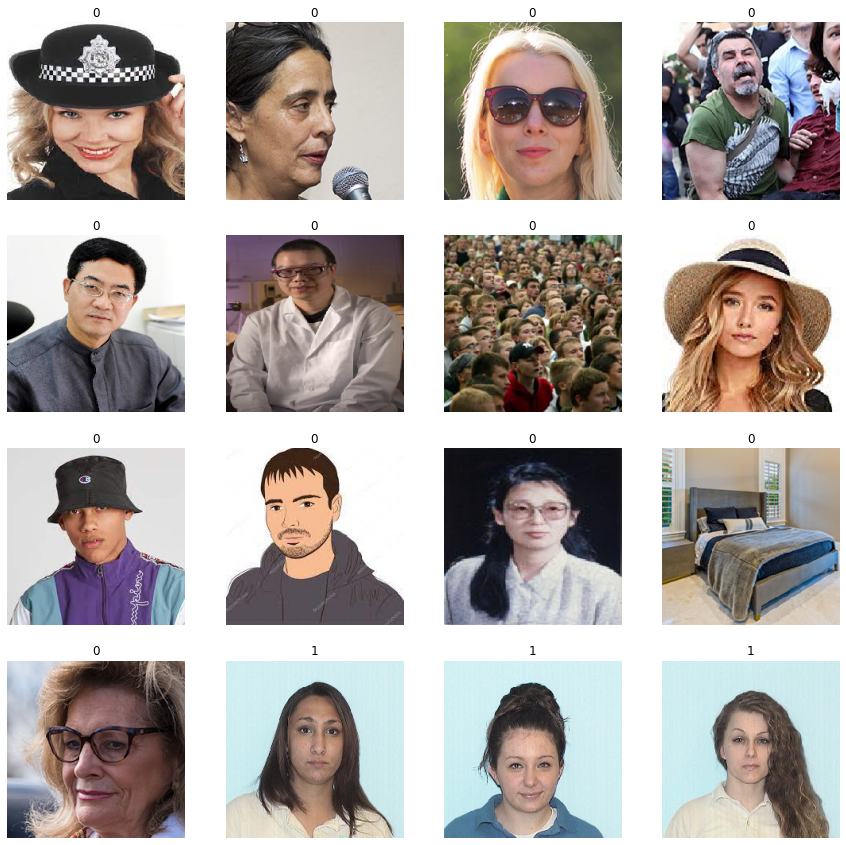

In [3]:
#Now visualize some images with coresponding classes
rows = 4

fig, axes = plt.subplots(rows,rows, figsize = (15,15))
for row in range(rows):
    for column in range(rows):
        axes[row][column].set_axis_off()
        
        img = random.choice(training_data)
        axes[row][column].imshow(img[0])
        axes[row][column].set_title(img[1], loc = 'center')
       

In [4]:
print(len(training_data))
print(training_data[0][0].shape)
#As we can see list of imgs arrays with corresponding classes was generated successfully 

2860
(224, 224, 3)


In [5]:
#Now lets shuffle our training data
random.shuffle(training_data)
random.shuffle(val_data)

In [6]:
X_train = []
Y_train_for_plt = []

for feature, Class in training_data:
    X_train.append(feature)
    Y_train_for_plt.append(Class)
    
X_train = np.array(X_train)
#One hot encoding Y_train
Y_train = to_categorical(np.array(Y_train_for_plt))

print(Y_train.shape)
print(X_train.shape)

(2860, 2)
(2860, 224, 224, 3)


In [7]:
X_val = []
Y_val_for_plt = []
for feature, Class in val_data:
    X_val.append(feature)
    Y_val_for_plt.append(Class)
    
X_val = np.array(X_val)
#One hot encoding Y_train
Y_val = to_categorical(np.array(Y_val_for_plt))


# Base model

In [12]:
input_tensor = Input(shape=(224, 224, 3))

#Extract features useing headless resnet with average pooling (to get (2800,2048) shape instead of (2800,7,7,2048))
base_model = ResNet50V2(include_top=False, input_tensor=input_tensor, weights='imagenet', pooling='avg', classes = 2)
#base_model.save('base_152.h5')
#features = base_model.predict(X_train)

#features.shape

In [13]:
base_model.trainable = False
base_model.summary()
print(len(base_model.layers))

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

# Visualizing headless resnet features with t-sne

In [10]:
from sklearn.manifold import TSNE

In [11]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40,learning_rate = 50, n_iter=300)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2800 samples in 0.009s...
[t-SNE] Computed neighbors for 2800 samples in 0.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2800
[t-SNE] Computed conditional probabilities for sample 2000 / 2800
[t-SNE] Computed conditional probabilities for sample 2800 / 2800
[t-SNE] Mean sigma: 5.984568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.025711
[t-SNE] KL divergence after 600 iterations: 1.332229


In [12]:
tsne_results.shape

(2800, 2)

In [13]:
import seaborn as sns 
import pandas as pd

In [14]:
labels = np.copy(Y_train_for_plt)
tsne_res = np.vstack((tsne_results.T, labels)).T
tsne_df = pd.DataFrame(data = tsne_res, columns = ('X', 'Y', 'label'))
print(tsne_df.shape)

(2800, 3)


In [15]:
#Let's take a look at few rows from tsne_df
print(tsne_df[0:5])

           X          Y  label
0 -10.450539  -0.878684    0.0
1  34.638721   6.285610    0.0
2   5.801630  10.430984    0.0
3 -30.341225  -7.320869    1.0
4   7.486475  -6.025032    1.0


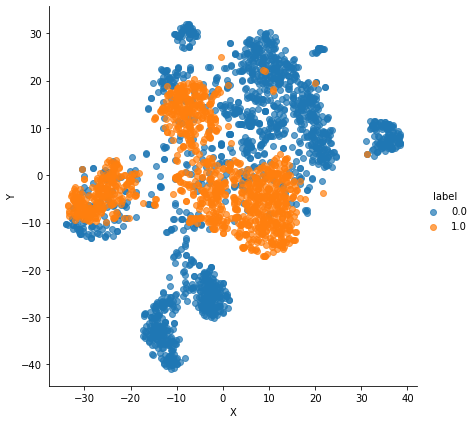

In [16]:
sns.FacetGrid(tsne_df, hue='label', height = 6).map(plt.scatter, 'X', 'Y', alpha = .7).add_legend()
plt.show()

# Transfer learning

In [14]:
#As we can see resnet with immagenet weights make quite good job in separating classes so we can add
#fully connected layer and try to train our model on new data
x = Flatten()(base_model.output)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)
predictions = Dense(2, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()
print(len(model.layers))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:
#model = load_model('resnet152_without_fine_tuning.h5')
#model = load_model('resnet50_without_fine_tuning.h5')


In [10]:
model.summary()
print(len(model.layers))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

# Training our model

In [22]:

OPTIMIZER = Adam(1e-4)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])
NUM_EPOCHS = 20
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10

history = model.fit(X_train, Y_train, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20
10/10 [==============================] - 25s 3s/step - loss: 0.0187 - accuracy: 0.9969
Epoch 2/20
10/10 [==============================] - 25s 3s/step - loss: 0.0037 - accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 24s 2s/step - loss: 0.0042 - accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 24s 2s/step - loss: 0.0116 - accuracy: 0.9969
Epoch 5/20
10/10 [==============================] - 24s 2s/step - loss: 0.0105 - accuracy: 0.9937
Epoch 6/20
10/10 [==============================] - 24s 2s/step - loss: 0.0243 - accuracy: 0.9969
Epoch 7/20
10/10 [==============================] - 25s 3s/step - loss: 0.0050 - accuracy: 1.0000
Epoch 8/20
10/10 [==============================] - 24s 2s/step - loss: 0.0027 - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 22s 2s/step - loss: 0.0027 - accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 24s 2s/step - loss: 0.0094 - accuracy: 0.9969
Epoch 11/20
10/10 [

# Checking performance and misclassified images

88/88 [==============================] - 444s 5s/step - loss: 0.0074 - accuracy: 0.9982


[0.007406444754451513, 0.9982143044471741]

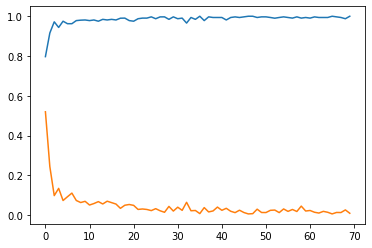

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
model.evaluate(X_train,Y_train)

In [23]:
preds = model.predict(X_val)

def classify(threshold, X, Y):
    preds = model.predict(X)
    classifications = (preds[:,1] >= threshold).astype(int)
    return classifications



def matrics(classifications, Y):
    compare = (classifications == Y.argmax(axis = 1)).astype(int)
    accuracy = compare.sum()/len(Y)
    
    
    t_p = 0
    f_p = 0
    t_n = 0
    f_n = 0
    
    Y = np.reshape(Y.argmax(axis = 1),(len(Y), 1))
    classifications = np.expand_dims(classifications, axis = 1)
    
    matrix = np.c_[Y,classifications]
    
    
    
    for row in matrix:
        if row.tolist() == [0,0]: #True Negative
            t_n += 1
            
        elif row.tolist() == [0,1]: #False Positive
            f_p += 1
            
        elif row.tolist() == [1,1]: #True Positife
            t_p += 1
            
        elif row.tolist() == [1,0]: #False Negative
            f_n += 1
            
    
     
    

    print(pd.DataFrame( [t_p,f_p,t_n,f_n], ['True Positives','False Positives','True Negatives','False Negatives'], ['Number']))
    
    print()
      
    print('True positives rate: ' + str(t_p/(t_p + f_n)) )
    print('False positives rate: ' + str(f_p/(f_p + t_n)))
    
    print('True negatives rate: ' + str(t_n/(t_n + f_p)))
    print('False negatives rate: ' + str(f_n/(f_n + t_p)))
    
    print()
    
    print('accuracy: ' + str(format(accuracy, ".4f")))
    
    
classifications = classify(0.5,X_val,Y_val)
matrics(classifications, Y_val)

                 Number
True Positives      150
False Positives       2
True Negatives      198
False Negatives       0

True positives rate: 1.0
False positives rate: 0.01
True negatives rate: 0.99
False negatives rate: 0.0

accuracy: 0.9943


[0.00119618 0.99880385]


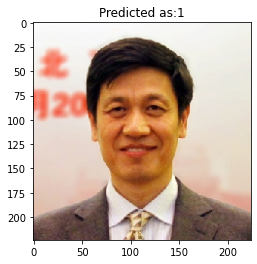

[0.0190697 0.9809303]


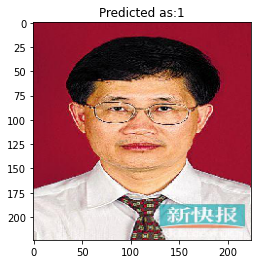

In [24]:
def plot_wrong_predictions(predictions, Y, X):
    compare = predictions == Y
    for (index, element) in enumerate(compare):
        if element == False:
            prob = model.predict(np.expand_dims(X[index], axis=0))
            print(prob[0])
            plt.imshow(X[index])
            plt.title('Predicted as:' + str(predictions[index]))
            plt.show()
            
plot_wrong_predictions(classifications,Y_val_for_plt,X_val)

Predicted as: 0
[0.9926884  0.00731157]


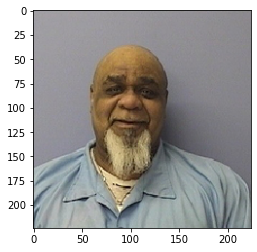

In [32]:
model = load_model('resnet50_final_model.h5')
def predict_image(path,threshold):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255.

    preds = model.predict(img)
    print('Predicted as: ' + str( (preds[:,1] >= threshold).astype(int)[0] ))
    print(preds[0])

    plt.imshow(img.reshape(img.shape[1:]))
    plt.show()

predict_image('test3.jpeg', 0.5)


In [25]:
#model.save('resnet50_after_new.h5')

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [69]:
#model.save('resnet101_final_model.h5')

# Now let's try to fine tune our base model with low lr

In [36]:
#model = load_model('resnet152_without_fine_tuning_70epochs.h5')
#model = load_model('resnet152_after_10e_all_l.h5')
print(len(model.layers))
for layer in model.layers[186:]:
    layer.trainable = True



196


In [37]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [30]:
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs = 10, batch_size = BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/10
10/10 [==============================] - 25s 2s/step - loss: 0.0065 - accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 25s 2s/step - loss: 0.0049 - accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 24s 2s/step - loss: 0.0268 - accuracy: 0.9906
Epoch 4/10
10/10 [==============================] - 24s 2s/step - loss: 0.0184 - accuracy: 0.9906
Epoch 5/10
10/10 [==============================] - 24s 2s/step - loss: 0.0056 - accuracy: 0.9969
Epoch 6/10
10/10 [==============================] - 24s 2s/step - loss: 0.0102 - accuracy: 0.9937
Epoch 7/10
10/10 [==============================] - 24s 2s/step - loss: 0.0126 - accuracy: 0.9969
Epoch 8/10
10/10 [==============================] - 24s 2s/step - loss: 0.0029 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 25s 2s/step - loss: 0.0240 - accuracy: 0.9933
Epoch 10/10
10/10 [==============================] - 24s 2s/step - loss: 0.0061 - accuracy: 0.9969


In [39]:
new_features = base_model.predict(X_val)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.004s...
[t-SNE] Computed neighbors for 350 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 6.887822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.927776
[t-SNE] KL divergence after 600 iterations: 0.741171


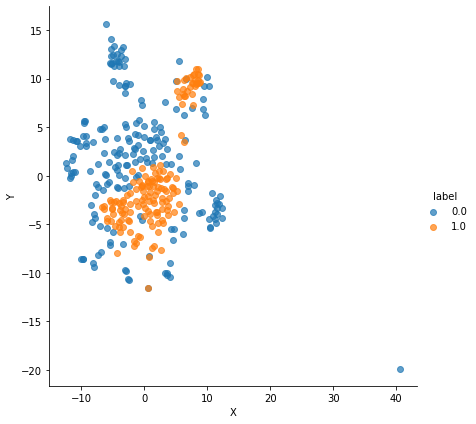

In [374]:
def plot_tsne(features):
    new_tsne_results = tsne.fit_transform(features)

    labels = np.copy(Y_val_for_plt)
    tsne_res = np.vstack((new_tsne_results.T, labels)).T
    tsne_df = pd.DataFrame(data = tsne_res, columns = ('X', 'Y', 'label'))

    sns.FacetGrid(tsne_df, hue='label', height = 6).map(plt.scatter, 'X', 'Y', alpha = .7).add_legend()
    plt.show()
plot_tsne(new_features)

In [31]:
preds = model.predict(X_val)
classifications = classify(0.5,X_val,Y_val)
matrics(classifications, Y_val)
#model.evaluate(X_train,Y_train)

                 Number
True Positives      150
False Positives       2
True Negatives      198
False Negatives       0

True positives rate: 1.0
False positives rate: 0.01
True negatives rate: 0.99
False negatives rate: 0.0

accuracy: 0.9943


In [33]:
#model.save('resnet50_tune.h5')

In [356]:
model.evaluate(X_train,Y_train)

88/88 [==============================] - 820s 9s/step - loss: 0.0935 - accuracy: 0.9550


[0.09354744106531143, 0.9549999833106995]